# Imports and constants

Let's first import all libraries needed and files constants.

In [1]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.formula.api as smf
from tqdm import tqdm

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
SRC = 'tweets/'
RAW_DATA = SRC + 'raw_data/'
DATA = SRC + 'data/'

#Tweet counts
MONTHLY_COUNT = SRC + 'monthly_count/'
TERRORISM_COUNT = MONTHLY_COUNT + 'short_terrorism.csv'
DOMESTIC_COUNT = MONTHLY_COUNT + 'domestic_security.csv'

#Sentiment analysis
MONTHLY_SENT = SRC + 'monthly_sentiment/'
TERRORISM_SENT = MONTHLY_SENT + 'short_terrorism.csv'
DOMESTIC_SENT = MONTHLY_SENT + 'domestic_security.csv'

DOMAINS = ['short_terrorism', 'domestic_security','short_terrorism_sentiment', 'domestic_security_sentiment']

Due to the large size of our dataset, only the aggregations are included in the github repository. The raw dataset is available [here](https://drive.google.com/drive/folders/1cjZ2Mw286f8JNPUlfYkcOO21SQDTDKd4?usp=sharing).

The original data folder architecture is as follows:
```
tweets
│       
│
└───raw_data
│   └───short_terrorism
│   |   └───abu_sayyaf/
│   |   └───al-qaeda/
│   |       ...
|   |
│   └───domestic_security
│   |   └───air_marshal/
│   |   └───border_patrol/
│   |       ...
│   
└───data
│   └───short_terrorism
│   |       abu_sayyaf.csv
│   |       al-qaeda.csv
│   |       ...
|   |
│   └───domestic_security
│   └───short_terrorism_sentiment
│   └───domestic_security_sentiment
|
└───monthly_count
|       short_terrorism.csv
|       domestic_security.csv
|
└───monthly_sentiment
|       short_terrorism.csv
|       domestic_security.csv

```

`raw_data` contains the data resulting from the scraping and `data` contains the same data organised by keyword in a more convenient format. From `data`, `monthly_count` and `monthly_sentiment` are computed and used for the analysis.

Only the folders `monthly_count` and `monthly_sentiment` are included on github as they are reasonably small and sufficient for the analysis.

# Scraping Tweets

In order to scrap the tweets containing the selected keywords we used the the Twint library that lets us choose the time period as well as filtering only tweets that contains a keyword. 
However the scrapping cannot be done from a notebook if we want to make use of parallelism.

The multi-threaded scrapping can be tested by running at the root:
```
cd twint
python multiprocessing-script.py
```
This will create a folder `sample_scrap` at the root of the project where the scrapped data will be written.

The main scrapping steps are illustrated bellow:

In [3]:
#Import the library
import twint
from config.keywords import * #Define the lists of keywords
from scripts.time_partition import create_keyword_partition 

In [4]:
#Create a list of list containing the keywords to search for and the time period
#Such a partition lets us run multiple threads and processes scrapping independently of each other
work = []
for keyword in terrorism_short_terms:
    work += create_keyword_partition(keyword, 4) #Returns a partition where each month is divided in 4 periods

work[:5]

[['abu_sayyaf', '2012-01-01', '2012-01-07'],
 ['abu_sayyaf', '2012-01-08', '2012-01-14'],
 ['abu_sayyaf', '2012-01-15', '2012-01-21'],
 ['abu_sayyaf', '2012-01-22', '2012-01-31'],
 ['abu_sayyaf', '2012-02-01', '2012-02-07']]

In [5]:
#This is the main Scrapping function where the use of Twint is showed
#Each process runs this function in parallel

def Scrap(term, since, until):
    """
    Scraps the tweets containing the keyword `term` in the time frame starting from `since`
    and ending on `until`.
    """
    print(term, ' from ', since, ' to ', until)
    c = twint.Config()
    c.Search = term
    c.Since = since
    c.Until = until
    
    #Create and define the folder in which we write the output
    folder = term
    if not os.path.isdir(folder):
        os.mkdir(term)
    c.Output = folder+'/'+since+'-'+term+".csv"
    c.Hide_output = True
    c.Store_csv = True
    twint.run.Search(c) #Start the scrapping

In [6]:
#Here is an sample output 
pd.read_csv(SRC + 'sample/raw_data.csv', index_col=0).head()

,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
id,,,,,,,,,,,,,,,,,,,,,
156404221326016512,156404221326016512,2012-01-09 16:57:26 CET,2012-01-09,16:57:26,100,36270749,qtaybi,Aybi Advincula,NaN,"""@LieeLuxuriant: Naparanoid naman ako. Nasa MM...",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
156372760732504066,156364678736527361,2012-01-09 14:52:26 CET,2012-01-09,14:52:26,100,31599828,cecilecd,Ces,NaN,@JoneJoanie yup we fought about it na last Sat...,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
156359804980445186,156359804980445186,2012-01-09 14:00:57 CET,2012-01-09,14:00:57,100,134240162,eavesdropann,#TeamSidney 🚹 eavesdropann,NaN,RT @ntarc Philippine President Warns Of Possib...,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
156339068186267649,156339068186267649,2012-01-09 12:38:33 CET,2012-01-09,12:38:33,100,53934450,jembautista,Jem,NaN,"RT Abu Sayyaf lang make kidnap you? Eww, cheap...",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
156252985314390016,156252054690607105,2012-01-09 06:56:29 CET,2012-01-09,06:56:29,100,47643,myrizalist,The Vulcan Of Taal,NaN,@moiragallaga It won't work against the wrist ...,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


# Aggregating by keywords

Once the scrapping done, the current file architecture is not partical to work with: due to the parallelized scrapping, we have one folder per keyword in which there is multiple files containing different periods scrapped. We sometimes divided the scrapping of a big keyword into weeks, resulting in 144 files for a single keyword.
We will aggregate the tweets into a single file per keyword for an easier handling of data.

In [7]:
def concat_files(domain='short_terrorism'):
    """
    Crawl in the specified directory and combine every time periods into one for each keyword.
    """
    walk = os.walk(RAW_DATA + domain)
    next(walk)
    
    if not os.path.isdir(DATA):
        os.mkdir(DATA)
    
    for root, dirs, filenames in walk:
        print(root[2:])
        combined_df = pd.concat([pd.read_csv(os.path.join(root, f)) for f in filenames])
        combined_df.to_csv(DATA + domain + root[2:] + ".csv")


Given the `raw_data` folder, all is left is to call the function twice: `concat_files('short_terrorism')` and `concat_files('domestic_security')` in order to create the `data` folder containing a single file for each keyword.

# Monthly tweet count

What we have now is a single file for each keyword, recording all tweets posted during our time frame. In order to analyze the evolution of the number of tweets, we need to count how many tweets are posted every month. The result will be two files in the `monthly_count` folder: `short_terrorism.csv` and `domestic_security.csv` containing the monthly tweet counts per keyword. 

In [8]:
def count_monthly_views(init, path, keyword):
    """
    Read the file at `path` and counts the number of tweets per month containing the `keyword`.
    :param init: empty dataframe listing every days of the time period, it is used to set the count of 
    days with no tweets to 0.
    :param path: file path to the csv
    :param keyword: keyword name
    """
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df.date)
    count = df.groupby("date").count()[['id']].rename(columns={'id':'tweets'})
    entire_period = (init + count).fillna(value=0)
    entire_period['tweets'] = entire_period.tweets.astype(int)
    entire_period['keyword'] = keyword
    return entire_period.reset_index()

def compute_count():
    """
    Computes the monthly views for every keyword and write the outputs in `monthly_count`
    """
    start_date = datetime(2012, 1, 1)
    end_date = datetime(2014,12,31)
    
    #Create an zero-filled df listing every days of the period in order to set the count of days
    #with no tweets to 0.
    dates = pd.date_range(start_date,end_date,freq='d', name='date')
    init = pd.DataFrame(data=np.zeros((len(dates),1)), columns=['tweets'],index=dates, dtype=int)
    
    for folder in DOMAINS[:2]:
        counts = pd.DataFrame(columns=["date", 'tweets', 'keyword'])
        for file in sorted(os.listdir(DATA + folder)):
            print(file)
            keyword = file.split('.csv')[0]
            counts = counts.append(count_monthly_views(init, DATA + folder + '/' + file, keyword))
        counts.to_csv(MONTHLY_COUNT + folder + '.csv')

Given the `data` folder, running `compute_count()` counts the  number of tweets per month for each keyword and write the outputs in `monthly_count`.

As described in the report, our input is two csv files, in the same format as the Wikipedia views from the paper but with a number of tweets per day and per subject instead. On this dataset, we will perform some cleaning, then exploration of the data, and finally an in-depth analysis.

# Loading

Now that the data scrapping is done let's start working on the data.

In [9]:
terrorism_raw = pd.read_csv(TERRORISM_COUNT, index_col=0)
domestic_raw = pd.read_csv(DOMESTIC_COUNT, index_col=0)

In [10]:
print(len(terrorism_raw))
terrorism_raw.head()

29592


,date,tweets,keyword
0,2012-01-01,7,abu_sayyaf
1,2012-01-02,1,abu_sayyaf
2,2012-01-03,5,abu_sayyaf
3,2012-01-04,22,abu_sayyaf
4,2012-01-05,93,abu_sayyaf


In [11]:
print(len(domestic_raw))
domestic_raw.head()

26304


,date,tweets,keyword
0,2012-01-01,11,air_marshal
1,2012-01-02,13,air_marshal
2,2012-01-03,9,air_marshal
3,2012-01-04,9,air_marshal
4,2012-01-05,7,air_marshal


Nothing to comment as of yet. We only have the columns that are of use to us, which are the date and keyword as well as the number of tweets for this combination

# Cleaning

In [12]:
# We check the types of the columns, as well as the number of keywords and dates
print('Columns types in the terrorism dataset: \n', terrorism_raw.dtypes)
print('Columns types in the domestic security dataset: \n', domestic_raw.dtypes)
print('Number of terrorism keywords: ', terrorism_raw.keyword.nunique())
print('Number of domestic security keywords: ', domestic_raw.keyword.nunique())
print('The number of dates in each dataset should be equal: {} and {}'.format(domestic_raw.date.nunique(), terrorism_raw.date.nunique()))

Columns types in the terrorism dataset: 
 date       object
tweets      int64
keyword    object
dtype: object
Columns types in the domestic security dataset: 
 date       object
tweets      int64
keyword    object
dtype: object
Number of terrorism keywords:  27
Number of domestic security keywords:  24
The number of dates in each dataset should be equal: 1096 and 1096


In [13]:
# Converting date types from String to datetime
terrorism_raw['date'] = pd.to_datetime(terrorism_raw.date)
domestic_raw['date'] = pd.to_datetime(domestic_raw.date)

In [14]:
# Checking that we do not have any invalid values
print(terrorism_raw.isna().sum())
print(domestic_raw.isna().sum())

date       0
tweets     0
keyword    0
dtype: int64
date       0
tweets     0
keyword    0
dtype: int64


In [15]:
# Checking that the dates start and end at the right time
print(terrorism_raw.date.min(), terrorism_raw.date.max())
print(domestic_raw.date.min(), domestic_raw.date.max())

2012-01-01 00:00:00 2014-12-31 00:00:00
2012-01-01 00:00:00 2014-12-31 00:00:00


In [16]:
terrorism_df = terrorism_raw.copy()
domestic_df = domestic_raw.copy()

Now that we know our datasets have no obvious anomalies, and all our data types are coherent, we can start the exploration phase.

# Exploration

In [17]:
def plot_keywords_monthly(df, sample=False):
    """
    For a given dataframe, plots the views per month. Plot a random keyword is `sample` is 
    `True` and all of them otherwise.
    """
    keywords = df.keyword.unique()
    
    if sample:
        index = np.random.randint(len(keywords))
        keywords = [keywords[index]]
        
    for keyword in keywords:
        monthly = df[df.keyword == keyword].groupby(pd.Grouper(key='date', freq='M')).sum()
        plt.figure(figsize=(15,3))
        sns.scatterplot(x='date', y='tweets', data=monthly)
        plt.title(keyword)
        plt.show()

The first exploratory step is to look at the views per keyword, but since we don't want to plot every day as it would be too many datapoints and be unreadable we will group them by month.

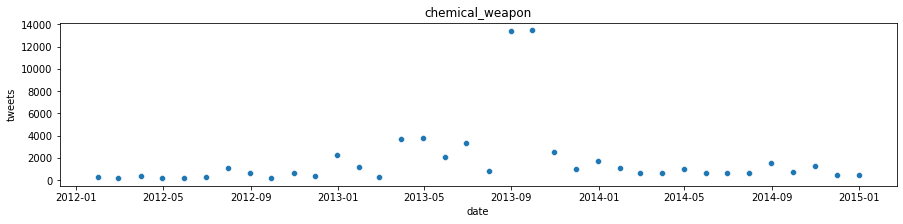

In [18]:
plot_keywords_monthly(terrorism_df, sample=True)

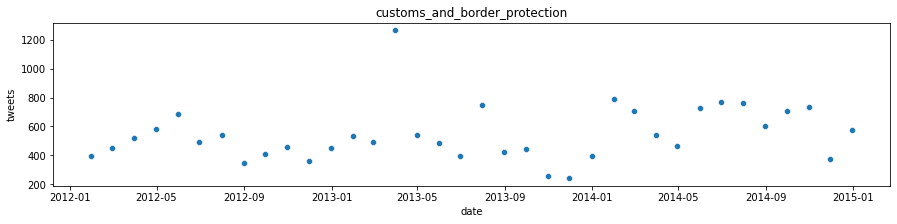

In [19]:
plot_keywords_monthly(domestic_df, sample=True)

We observe that for individual keywords, the tweet count is quite irregular. Let us look at the global trend by aggregating every keyword.

In [20]:
monthly_terrorism_df = terrorism_df.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()
monthly_domestic_df = domestic_df.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()

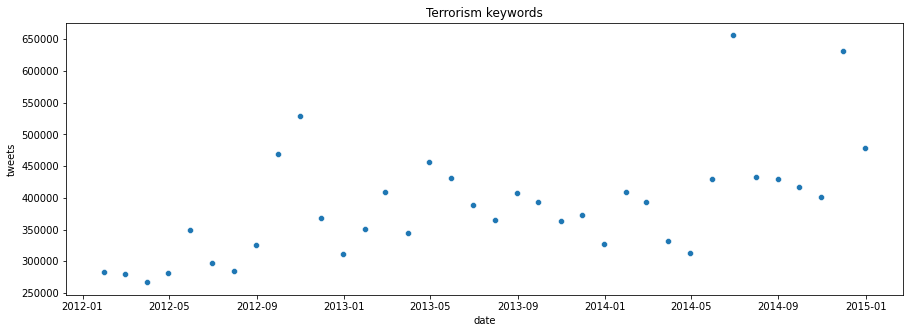

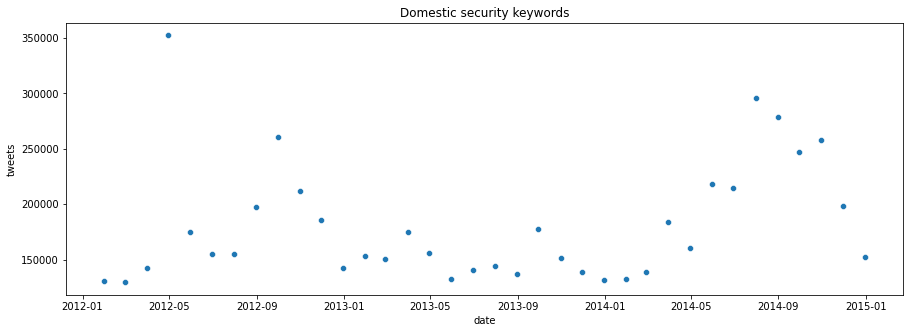

In [21]:
def plot_global_trend(df, title):
    """Plot the number of tweets per day contained in the given dataframe."""
    plt.figure(figsize=(15,5))
    sns.scatterplot(x='date', y='tweets', data=df)
    plt.title(title)

plot_global_trend(monthly_terrorism_df, 'Terrorism keywords')
plot_global_trend(monthly_domestic_df, 'Domestic security keywords')

Here the data is not as irregular but we still have some peaks at various points in time and not a stable trend. However, we might have a few keywords with a high number of tweets skewing our results. We will try to do the same plots, but we will first process the dataset in the following way: 

For each keyword, we will normalize the number of tweets each month by dividing it by the maximum number of tweets on any given month, so that the resulting value is between 0 and 1, but the trend will look the same. This way every keyword gives an equal contribution to the global trend. 
This makes sense because we are interested in trends for each keyword individually, and this will not be modified by this operation.

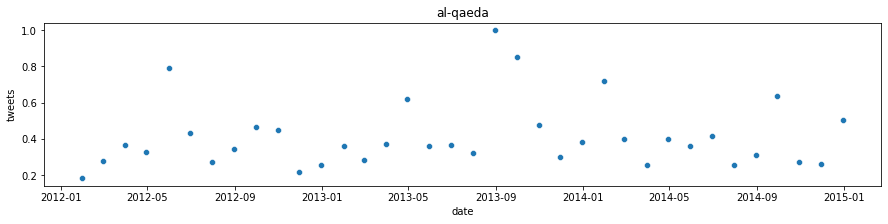

In [22]:
# Here is an example of this operation on a single keyword :
keyword = 'al-qaeda'
monthly = terrorism_df[terrorism_df.keyword == keyword].groupby(pd.Grouper(key='date', freq='M')).sum()
monthly['tweets'] = monthly.tweets/monthly.tweets.max() # Here we divide by max tweets in a month
plt.figure(figsize=(15,3))
sns.scatterplot(x='date', y='tweets', data=monthly)
plt.title(keyword)
plt.show()
# As we can see, the only the y-axis changed, but the relative values are the same

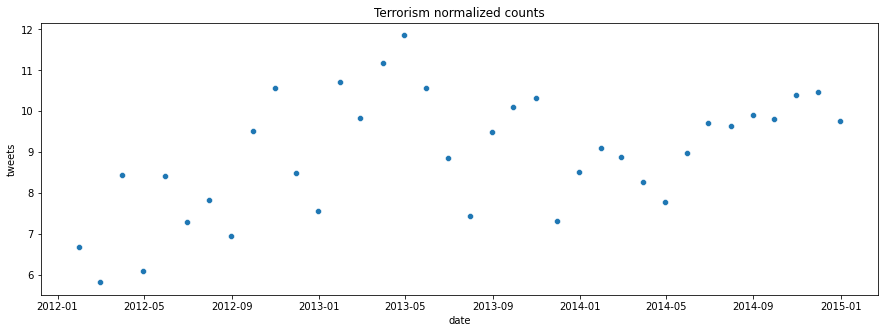

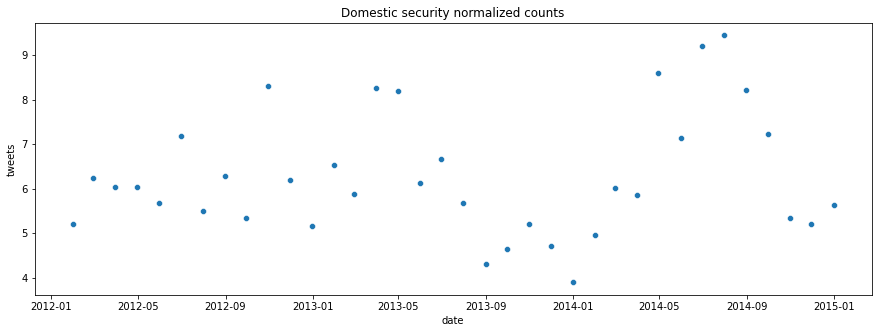

In [23]:
# Now we apply this operation on all keywords before summing
def normalize_df_and_plot_monthly(df, title):
    """Normalize the keywords in df by dividing the keywords counts by their respective maximum monthly counts."""
    copy = df.copy()
    for keyword in copy.keyword.unique():
        #Compute the monthly counts
        monthly = copy[copy.keyword == keyword].groupby(pd.Grouper(key='date', freq='M')).sum()
        #Normalize the current keyword counts
        copy.tweets = np.where(copy.keyword == keyword, copy.tweets/monthly.tweets.max(), copy.tweets)
    norm_monthly_df = copy.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()
    
    #Plot the normalized dataframe
    plt.figure(figsize=(15,5))
    sns.scatterplot(x='date', y='tweets', data=norm_monthly_df)
    plt.title(title)
    return norm_monthly_df

normalized_terrorism_df = normalize_df_and_plot_monthly(terrorism_df, 'Terrorism normalized counts')
normalized_domestic_df = normalize_df_and_plot_monthly(domestic_df, 'Domestic security normalized counts')

However an issue arises now because keywords with very few tweets might be very irregular since stability comes from having a lot of users taking turns tweeting about a subjects. For instance, the trend of a keyword that is only tweeted by 10 people might be severely affected if only one of them stops. We will look at the mean number of tweets per subject and take out keywords with under 100 tweets per day on average.

In [24]:
def eliminate_low_tweets(df):
    df_means = df.groupby(pd.Grouper(key='keyword')).mean()
    nb_keywords = df_means.index.nunique()
    df_means = df_means[df_means.tweets > 100.0]
    new_nb_keywords = df_means.index.nunique()
    print('Eliminated {} keywords out of {}'.format(nb_keywords - new_nb_keywords, nb_keywords))
    return df[df.keyword.isin(df_means.index)]

filtered_terrorism_df = eliminate_low_tweets(terrorism_df)
filtered_domestic_df = eliminate_low_tweets(domestic_df)

Eliminated 16 keywords out of 27
Eliminated 17 keywords out of 24


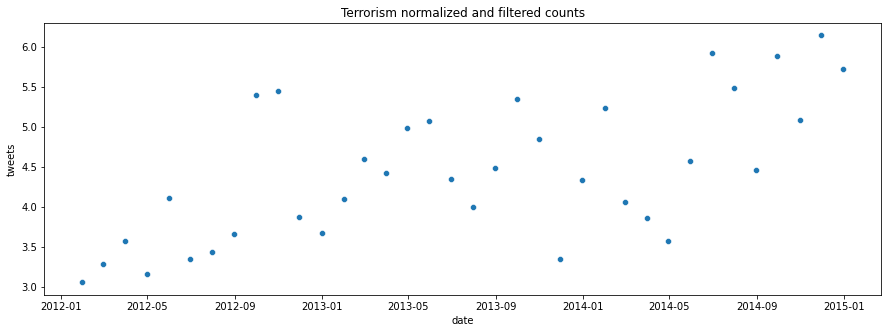

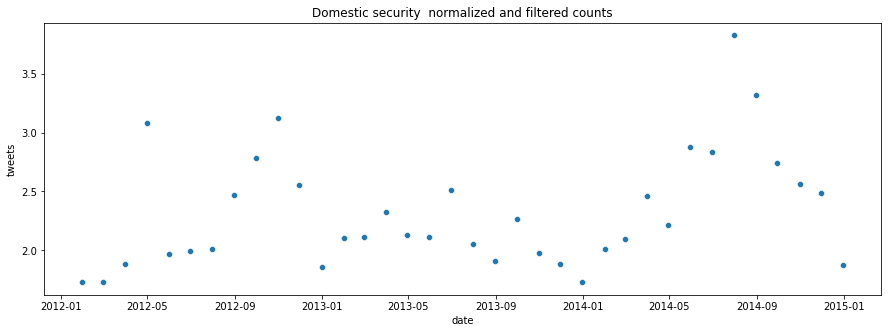

In [25]:
final_terrorism_df = normalize_df_and_plot_monthly(filtered_terrorism_df, 'Terrorism normalized and filtered counts')
final_domestic_df = normalize_df_and_plot_monthly(filtered_domestic_df, 'Domestic security  normalized and filtered counts')

The trends look somewhat smoother now. We can proceed with the analysis

# Data analysis

In [26]:
# We start by merging both dataframes
total_tweets = final_domestic_df.copy()
total_tweets = total_tweets.rename(columns={"tweets": "tweets_security"})
total_tweets['tweets_terrorism'] = final_terrorism_df['tweets']

# Then we sort by month, and reset the index to have them numbered in increasing order
total_tweets = total_tweets.sort_values('date')
total_tweets.head()

,date,tweets_security,tweets_terrorism
0,2012-01-31,1.727746,3.054700
1,2012-02-29,1.734141,3.290300
2,2012-03-31,1.886777,3.568069
3,2012-04-30,3.081733,3.156634
4,2012-05-31,1.971143,4.112672


Now we perform the Interrupted Time Series analysis

The regression formula is as follows : $$Y_t = \beta_0 + \beta_1\times time + \beta_2\times intervention + \beta_3\times postslope + \epsilon_{1}$$

Where $Y_t$ is the views at time $t$, the $\beta$ are the parameters of the model, and $\epsilon_1$ is the residuals

There are 3 variables that are used to predict the total views :

`time`, `intervention` and `postslope`. I will create a column for each in the dataframe :

- Time: This is just the current month, from 1 to 32
- Intervention: Whether or not the interruption has happened already (0 for the first 17 months, then 1)
- Postslope: The time since the interruption (0 for the first 17 months, then $time - 17$)

In [27]:
# Now we create those variables in our dataframe
def create_ITS_variables(df):
    df['time'] = df.index+1
    df['intervention'] = np.where(df['time'] <= 17, 0, 1)
    df['postslope'] = (df.time - 17) * df.intervention
    
create_ITS_variables(total_tweets)

In [28]:
# Now that all our variables are ready, we can fit our regressions (one for each dataset)
def regression_model(df, name, prefix='tweets'):
    # Declaring the model
    print('\n{} model :'.format(name))
    model = smf.ols(formula='{}_{} ~ time + intervention + postslope'.format(prefix, name), data=df)

    # Fitting the model
    np.random.seed(1)
    result = model.fit()

    # Checking the results
    print(result.summary())
    return result

result_terrorism = regression_model(total_tweets, 'terrorism')
result_security = regression_model(total_tweets, 'security')


terrorism model :
                            OLS Regression Results                            
Dep. Variable:       tweets_terrorism   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     9.990
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           8.46e-05
Time:                        18:32:59   Log-Likelihood:                -33.905
No. Observations:                  36   AIC:                             75.81
Df Residuals:                      32   BIC:                             82.14
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.1010      

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


For the first model, the terrorism keywords, we find an adjusted R-squared value of 0.435, which means that even when accounting for the number of parameters, there is quite a strong explanatory power. Indeed, our p-value for `time` is very close to zero, and even though the p-value for `intervention` is higher, is is still under 0.05, which suggests a significance in this result. On the other hand, the p-value of `postslope` is greater than 0.05 which  means that the statistical significance for this parameter is very weak. So overall, the results point to an immediate decrease in tweets after the Snowden revelations (intervention = -0.37) but no significant change in the upwards post-intervention trend.

For the second model, we only have R-squared = 0.164 which is not very high, but when adjusting for the number of parameters, the explanatory power falls to 0.086. Furthermore, all p-values are above 0.2, only suggesting at best a very weak predictive power for both `intervention` and `postslope`. It seems like the model is not very relevant for this set of keywords. This is expected from keywords which were not supposed to be affected by Chilling Effects.

In [29]:
# We now have the parameters of our model, so we can make our predictions for the total tweets per month
# We also produce 95% confidence intervals
def predict(result, df, name):
    beta_0 = result.params['Intercept']
    beta_1 = result.params['time']
    beta_2 = result.params['intervention']
    beta_3 = result.params['postslope']
    confidence = result.get_prediction(df).conf_int(alpha=0.05)
    df['prediction_{}'.format(name)] = beta_0 + beta_1*df.time + beta_2*df.intervention + beta_3*df.postslope
    df['confidence_lower_{}'.format(name)] = confidence[:, 0]
    df['confidence_upper_{}'.format(name)] = confidence[:, 1]
    
predict(result_terrorism, total_tweets, 'terrorism')
predict(result_security, total_tweets, 'security')
total_tweets.head()

,date,tweets_security,tweets_terrorism,time,intervention,postslope,prediction_terrorism,confidence_lower_terrorism,confidence_upper_terrorism,prediction_security,confidence_lower_security,confidence_upper_security
0,2012-01-31,1.727746,3.054700,1,0,0,3.208570,2.585918,3.831223,2.126097,1.680309,2.571886
1,2012-02-29,1.734141,3.290300,2,0,0,3.316172,2.749064,3.883280,2.139692,1.733671,2.545714
2,2012-03-31,1.886777,3.568069,3,0,0,3.423773,2.909635,3.937912,2.153287,1.785190,2.521385
3,2012-04-30,3.081733,3.156634,4,0,0,3.531375,3.066750,3.996000,2.166882,1.834234,2.499531
4,2012-05-31,1.971143,4.112672,5,0,0,3.638977,3.219184,4.058769,2.180478,1.879927,2.481028


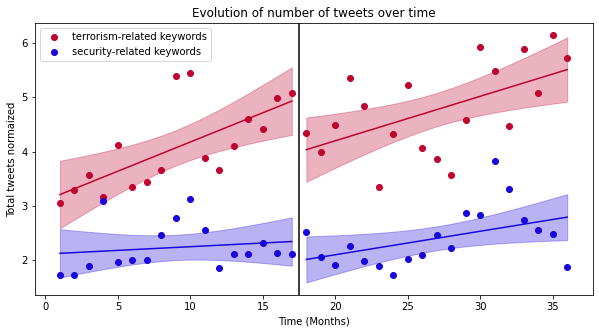

In [30]:
# Finally, we plot the results with 95% confidence intervals
def plot_half(half, df, color, prefix, label='__nolegend__'):
    x = half['time']
    plt.plot(x, half['prediction_{}'.format(df)], color=color)
    plt.scatter(x, half['{}_{}'.format(prefix, df)], color=color, label=label)
    plt.fill_between(x, half['confidence_lower_{}'.format(df)], half['confidence_upper_{}'.format(df)], color=color, alpha=0.3)

def plot_predictions(df, name, color, prefix='tweets'):
    pre_interruption = df[:17]
    post_interruption = df[17:]
    plot_half(pre_interruption, name, color, prefix, label='{}-related keywords'.format(name))
    plot_half(post_interruption, name, color, prefix)
    
    

plt.figure(figsize=(10,5))
plot_predictions(total_tweets, 'terrorism', 'xkcd:lipstick red')
plot_predictions(total_tweets, 'security', 'xkcd:ultramarine blue')
plt.axvline(17.5, color='black', label='_nolegend_')
plt.xlabel('Time (Months)')
plt.ylabel('Total tweets normaized')
plt.title("Evolution of number of tweets over time")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend()
plt.show()

In accordance with the model parameters commented above, we observe a drop in tweets following the Snowden revelations, but no change in the trend for the terrorism keywords
For the security keywords, there is almost no drop, and only a very slight change in trend (going up)

# Sentiment analysis

The value of analyzing tweets is the fact that we can extract more information from Tweets than pageviews. By performing a sentiment analysis on the tweets containing one of the selected keywords, we can check if the sentiments expressed by users were influenced by the revelations. One hypothesis may be that users would refrain to express positive opinions concerning terrorism matters after the revelations.

## Data processing

Here is the plan: first extract the sentiment of each tweets, and then aggregate the values monthly for each keyword. This way we can perform an ITS on the evolution of the sentiments.

### Sentiment extraction

For each Tweet we compute the proportion of Negative, Neutral and Positive sentiment. We also extract the Compound value that is a normalized sum of all the sentiment, providing a handy single-value aggregate. The compound value can be considered positive when greater than 0.5, neutral between 0.5 and -0.5 and negative bellow -0.5.

In [31]:
#NLP libraries
import spacy
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/julien/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Here is an illustration of the sentiment analysis class from Vader, used on tweets from the `Abu sayyaf` tweets. It extracts the proportion of each sentiment and computes the compound value.

In [32]:
analyser = SentimentIntensityAnalyzer()
sample_str_1 = "Philippine kidnappers believed linked to the Islamist group Abu Sayyaf demand a $2 million ransom for Australian hostage."
print(sample_str_1 , analyser.polarity_scores(sample_str_1), sep='\n', end='\n\n')

sample_str_2 = 'Hahaha! RT @SheQuebral @Jimparedes “@Jimparedes: #ItsMoreFunInThePhilippines From hereon, Abu Sayyaf will be renamed Abu SAYA!” LOL !!!'
print(sample_str_2 , analyser.polarity_scores(sample_str_2), sep='\n')

Philippine kidnappers believed linked to the Islamist group Abu Sayyaf demand a $2 million ransom for Australian hostage.
{'neg': 0.086, 'neu': 0.914, 'pos': 0.0, 'compound': -0.128}

Hahaha! RT @SheQuebral @Jimparedes “@Jimparedes: #ItsMoreFunInThePhilippines From hereon, Abu Sayyaf will be renamed Abu SAYA!” LOL !!!
{'neg': 0.0, 'neu': 0.644, 'pos': 0.356, 'compound': 0.8519}


In [33]:
def compute_sentiment(df):
    """
    Compute the sentiment proportion for each tweet in the specified dataframe.
    """
    analyser = SentimentIntensityAnalyzer()
    df['sentiment'] = df['tweet'].apply(lambda x: analyser.polarity_scores(x))
    for sent in ['neg', 'neu', 'pos', 'compound']:
        df[sent] = df['sentiment'].apply(lambda x: x.get(sent))

In [34]:
def sentiment_analysis(source_folder):
    """
    For every keywords computes the sentiment analysis of the tweets. 
    The proportions are added in new columns and the resulting dataframes are 
    written in the `data` folder.
    """
    source_dir = os.listdir(source_folder)
    for file in source_dir[6:]:
        dataframe = pd.read_csv(source_folder+file)
        compute_sentiment(dataframe)
        save_dir = source_folder[:-1]+"_sentiment/"
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        dataframe.to_csv(save_dir+file)

Given the `data` folder, running `sentiment_analysis(DATA + DOMAINS[0])` and `sentiment_analysis(DATA + DOMAINS[1])` performs the sentiment extraction on the tweets.

### Monthly agreggation

After the sentiment extraction is done, we now compute the mean proportions by month in order to analyse the evolution of the sentiments.

In [35]:
def monthly_mean(folder, csv_name):
    """
    For each keyword, aggregates the sentiment proportitions by month through averaging and
    write the resulting dataframe in a csv.
    :param folder: folder path where are stored all the keyword csv's
    :param csv_name: name of the output csv containing the aggregation
    """
    
    #Incrementally build a dataframe containing all the keywords monthly averages
    cols = ['date','keyword','neg','neu','pos', 'compound']
    sentiment_df = pd.DataFrame(columns=cols) #final df
    for filename in tqdm(os.listdir(folder)):
        keyword = pd.read_csv(folder + filename)
        
        keyword['date'] = pd.to_datetime(keyword.date, errors='coerce') #Convert dates from string to datetimes
        keyword = keyword[~keyword.date.isna()] #Remove Nan values
        
        monthly_mean = keyword.groupby(pd.Grouper(key='date', freq='M')).mean() #Monthly average
        monthly_mean['keyword'] = filename.split('.csv')[0] #Extract the keyword name
        monthly_mean = monthly_mean.reset_index()[cols]
        sentiment_df = pd.concat([sentiment_df, monthly_mean]) #Store result in final df
    sentiment_df.to_csv(MONTHLY_SENT + csv_name)

Given the `data` folder and the previously sentiment extfactions, running `monthly_mean(DATA + DOMAINS[2], 'short_terrorism.csv')` and `monthly_mean(DATA + DOMAINS[3], 'domestic_security.csv')` computes the monthly sentiment average per keyword.

## Analysis

Now that we have data aggregated by month, we will combine all keywords and inspect the general trends re-using the ITS analysis.

In [36]:
#First load the files and convert the dates from string to datetime objects for easier use
terrorism_keyword_raw = pd.read_csv(MONTHLY_SENT + 'short_terrorism.csv', index_col=0)
domestic_keyword_raw = pd.read_csv(MONTHLY_SENT + 'domestic_security.csv', index_col=0)
terrorism_keyword_raw['date'] = pd.to_datetime(terrorism_keyword_raw.date)
domestic_keyword_raw['date'] = pd.to_datetime(domestic_keyword_raw.date)

In [37]:
terrorism_keyword_raw.head()

,date,keyword,neg,neu,pos,compound
0,2012-01-31,abu_sayyaf,0.089470,0.879476,0.031047,-0.111974
1,2012-02-29,abu_sayyaf,0.158325,0.826464,0.015210,-0.319260
2,2012-03-31,abu_sayyaf,0.097435,0.873979,0.028590,-0.143835
3,2012-04-30,abu_sayyaf,0.141879,0.817297,0.040834,-0.217376
4,2012-05-31,abu_sayyaf,0.060284,0.894125,0.045606,-0.046395


To summarize, we have for each keyword the monthly averages of every sentiments: negative, neutral, positive and the compound value.

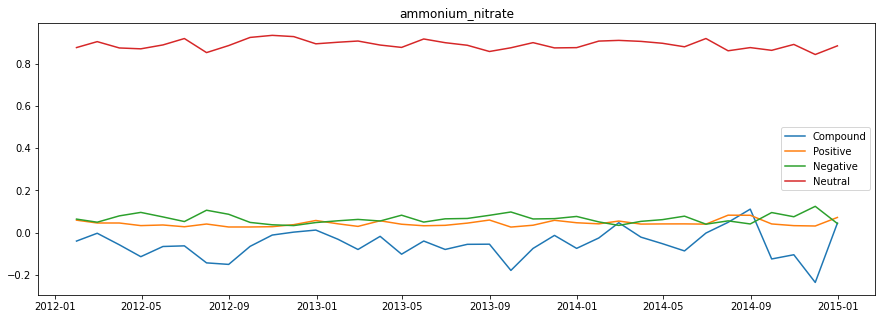

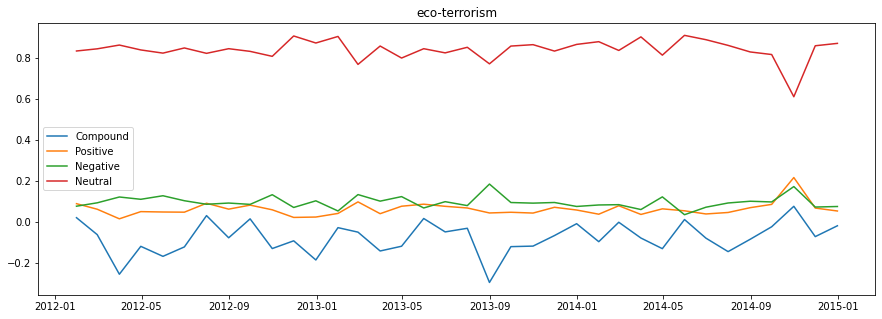

In [38]:
def plot_keyword_sentiment(df, sample=False):
    """
    Plots the sentiment proportions and the compound value for all the keywords. If `sample` is True
    then plots a random keyword.
    """
    keywords = df.keyword.unique()
    if sample:
        index = np.random.randint(len(keywords))
        keywords = [keywords[index]]
        
    for keyword in keywords:
        plt.figure(figsize=(15,5))
        keyword_df = df[df.keyword == keyword]
        plt.plot(keyword_df.date, keyword_df.compound, label='Compound')
        plt.plot(keyword_df.date, keyword_df.pos, label='Positive')
        plt.plot(keyword_df.date, keyword_df.neg, label='Negative')
        plt.plot(keyword_df.date, keyword_df.neu, label='Neutral')
        plt.legend()
        plt.title(keyword)
        plt.show()
    
plot_keyword_sentiment(terrorism_keyword_raw, sample=True)
plot_keyword_sentiment(terrorism_keyword_raw, sample=True)

From here, we can already see that the most represented sentiment is the neutral by far. There seems to be some fluctuations among the other sentiments but no trend of sudden drop off.
We will now inspect the general trend by aggregating all the keywords.

Let's filter the same keywords as for the tweet counts: by averaging the keywords, ones with few tweets will have the same weight as the others with a lot of tweets, so we filter out keywords with not enough tweets.

In [39]:
terrorism_keyword = terrorism_keyword_raw[terrorism_keyword_raw.keyword.isin(filtered_terrorism_df.keyword.unique())]
domestic_keyword = domestic_keyword_raw[domestic_keyword_raw.keyword.isin(filtered_domestic_df.keyword.unique())]

In [40]:
def aggregate_keywords(df):
    "Compute the mean sentiment proportions across all the keywords"
    df = df.groupby('date').mean().reset_index()
    df['date'] = pd.to_datetime(df.date) 
    return df

terrorism = aggregate_keywords(terrorism_keyword)
domestic = aggregate_keywords(domestic_keyword)

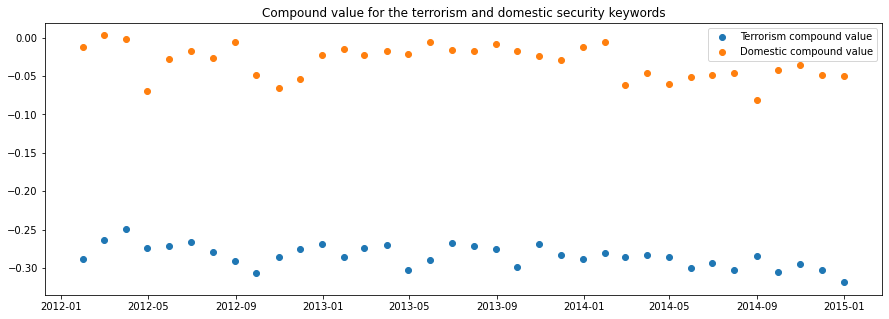

In [41]:
#Compare the general compound values of terrorism and domestic security tweets
plt.figure(figsize=(15,5))
plt.scatter(terrorism.date, terrorism.compound, label='Terrorism compound value')
plt.scatter(domestic.date, domestic.compound, label='Domestic compound value')
plt.legend()
plt.title("Compound value for the terrorism and domestic security keywords")
plt.show()

While we can see that the terrorism keywords have a more negative connotation than the domestic security keywords, there doesn't seem to be any effect due to the June 2013 revelations: the trends are constants and there are no big drop off from what we can see. Let's continue and evaluate the statistical significance.

In [42]:
#Create the variables used in the ITS: time, intervention and postslope
sentiments = pd.merge(terrorism, domestic, on=['date'], suffixes=('_terrorism', '_domestic'))
create_ITS_variables(sentiments)
sentiments.head()

,date,neg_terrorism,neu_terrorism,pos_terrorism,compound_terrorism,neg_domestic,neu_domestic,pos_domestic,compound_domestic,time,intervention,postslope
0,2012-01-31,0.197723,0.757652,0.044552,-0.287601,0.088590,0.824255,0.087156,-0.012219,1,0,0
1,2012-02-29,0.180796,0.769904,0.049279,-0.263336,0.089868,0.819045,0.091085,0.002857,2,0,0
2,2012-03-31,0.180347,0.769591,0.050042,-0.249281,0.089322,0.820601,0.090078,-0.001514,3,0,0
3,2012-04-30,0.187159,0.765631,0.047203,-0.273541,0.112880,0.805753,0.081365,-0.069772,4,0,0
4,2012-05-31,0.184977,0.767072,0.047943,-0.271864,0.097445,0.817812,0.084741,-0.027881,5,0,0


In [43]:
#Fit an Ordinary Least Square for the domestic security and terrorism keywords
result_terrorism_sentiment = regression_model(sentiments, 'terrorism', prefix='compound')
result_domestic_sentiment = regression_model(sentiments, 'domestic', prefix='compound')


terrorism model :
                            OLS Regression Results                            
Dep. Variable:     compound_terrorism   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     9.355
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           0.000137
Time:                        18:33:03   Log-Likelihood:                 112.62
No. Observations:                  36   AIC:                            -217.2
Df Residuals:                      32   BIC:                            -210.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2685      

The terrorism model is statistically significant (Prob > F = 0.001) and the R-squared is 0.467, the model explains a lot of the variance and has a high predictive power.  Among the coefficient only the `postslope` is not statistically significant with a p-value of 0.303 while the other coefficients are all smaller than 0.05. Yet, apart from the `intercept`, the coefficient are really close to zero.
Therefore we can conclude that there is no statistically significant drop off or change of trend after the intervention. 

The domestic model is also statistically significant (P > F = 0.01) and the R-squared is 0.295, so the predictive power is relatively high, though lower than the terrorism model. Only the `intercept` is statistically significant, with a p-value of 0.018. All the other coefficients have a p-value greater than 0.05. Moreover the coefficients are all close to zero so we cannot deduce any significant trend or drop-off either.

In [44]:
#Let's plot the keywords average compound values
predict(result_terrorism_sentiment, sentiments, 'terrorism')
predict(result_domestic_sentiment, sentiments, 'domestic')

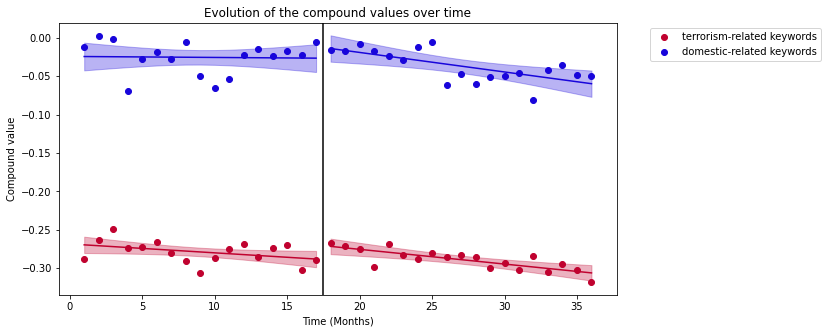

In [45]:
plt.figure(figsize=(10,5))
plot_predictions(sentiments, 'terrorism', 'xkcd:lipstick red', 'compound')
plot_predictions(sentiments, 'domestic', 'xkcd:ultramarine blue', 'compound')
plt.axvline(17.5, color='black', label='_nolegend_')
plt.xlabel('Time (Months)')
plt.ylabel('Compound value')
plt.title("Evolution of the compound values over time")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Coherently with the statistical analysis of the linear regression models, we can see that there is no influence from the June 2013 revelations, neither as a drop or a change of trend. Some limitations of our sentiment analysis may come from the scrapped data: we can find a lot of news tweets in the scrapped that can anchor the overall sentiments as news Twitter accounts may be less influenced by a possible chilling effect. An extension would be to filter them out before the analysis.